<div align="center">
    <h1>Aprendizaje automático</h1>
    <h3>Fundamentos y aplicaciones en meteorología del espacio</h3>
    <h4>TP 1: Clasificación</h4>
     <h5>Alumno: Federico Iza</h5>
</div>

# Clasificación de CMEs

In [1]:
import pandas as pd
from tp1_radar_settings import *
import matplotlib.pyplot as plt
from utils.plot import config_plots
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
import tensorflow as tf

2022-08-24 18:04:09.655479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-24 18:04:09.655526: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%matplotlib inline
config_plots()

## Adquisición de datos

In [3]:
df = pd.read_csv('../data/CMEs.csv')
df.rename(columns={'vprop': 'Velocity'}, inplace=True)

In [4]:
df.head()

,SunActivity,Velocity,Origin
0,low,592,flare
1,low,355,flare
2,low,619,flare
3,high,309,flare
4,high,1557,flare


## Preprocesamiento de datos

Se asigna 0 a baja intensidad solar y 1 a alta intensidad solar; por otro lado, se asigna al origen un 1 si es *flare* y 0 si no lo es.

In [5]:
# Numerical data has to be used in ANNs
numerical_origin = {'flare': 1, 'no flare': 0}
df['Origin'] = df['Origin'].map(numerical_origin)

numerical_activity = {'low': 0, 'high': 1}
df['SunActivity'] = df['SunActivity'].map(numerical_activity)

In [6]:
df.head()

,SunActivity,Velocity,Origin
0,0,592,1
1,0,355,1
2,0,619,1
3,1,309,1
4,1,1557,1


Chequeo si hay datos inválidos en el dataset:

In [7]:
np.sum(df == np.nan)

SunActivity    0
Velocity       0
Origin         0
dtype: int64

## Ingeniería de datos

### Balaceo de datos

In [8]:
data_balace = df['Origin'].value_counts()
print(data_balace)

1    39
0    26
Name: Origin, dtype: int64


In [9]:
# Remove data to balance dataset
counter = 13  # Remove the first 99 rows with target=1
df_aux = pd.DataFrame()
for idx, row in df.iterrows():
    if counter > 0:
        if row['Origin'] == 1:
            counter -= 1
        else:
            df_aux = pd.concat([df_aux, pd.DataFrame(row).T],
                               axis=0,
                               ignore_index=True)
    else:
        df_aux = pd.concat([df_aux, pd.DataFrame(row).T],
                           axis=0,
                           ignore_index=True)

In [10]:
data_balace = df_aux['Origin'].value_counts()
print(data_balace)

1    26
0    26
Name: Origin, dtype: int64


In [11]:
df_aux.describe()

,SunActivity,Velocity,Origin
count,52.000000,52.000000,52.000000
mean,0.653846,697.346154,0.500000
std,0.480384,395.119485,0.504878
min,0.000000,232.000000,0.000000
25%,0.000000,408.500000,0.000000
50%,1.000000,551.500000,0.500000
75%,1.000000,880.750000,1.000000
max,1.000000,1968.000000,1.000000


## Preparación de datos

In [12]:
features = df_aux.loc[:, df_aux.columns != 'Origin'].copy()
target =  df_aux.loc[:, df_aux.columns == 'Origin'].copy()

In [13]:
(feats_train, feats_test,
 target_train, target_test) = train_test_split(features, target,
                                               test_size=TEST_SIZE)

### Escalado de datos

In [14]:
scaler = MinMaxScaler()
feats_train.loc[:, 'Velocity'] = scaler.fit_transform(
    np.array(feats_train['Velocity']).reshape(-1, 1))

In [15]:
feats_train

,SunActivity,Velocity
50,0,0.158986
21,0,0.318548
16,1,0.166475
0,0,1.000000
3,0,0.493664
17,1,0.040323
44,1,0.297235
25,1,0.347926
36,1,0.252880
30,0,0.000000


In [16]:
feats_test['Velocity'] = scaler.transform(
    np.array(feats_test['Velocity']).reshape(-1, 1))

In [17]:
feats_test

,SunActivity,Velocity
43,1,0.304147
40,1,0.183756
46,1,0.463134
51,0,0.152650
4,0,0.127304
49,0,0.045507
41,1,0.713710
11,1,0.486751
35,1,0.326037
45,1,0.179724


## Modelado

In [18]:
input_size = feats_train.shape[1]  # Number of feats for training
print(input_size)

2


In [19]:
# Define ANN architecture
models = []

for i in range(len(models_params.keys())):
    # Instance the model
    model = Sequential()

    for j in range(models_params[f'm{i}']['N_LAYERS']):
        model.add(Dense(units=models_params[f'm{i}']['N_NEURONS'][j],
                        input_dim=input_size))
        model.add(Activation(models_params[f'm{i}']['ACTIVATION_FUNCTIONS'][j]))

    # Complile model
    model.compile(loss=LOSS_FUNCTION,  # Select loss function
                  optimizer=OPTIMIZER,  # Select optimizer
                  metrics=[tf.keras.metrics.Accuracy()])

    # Append model to list of models
    models.append(model)

2022-08-24 18:04:11.541417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-24 18:04:11.541443: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-24 18:04:11.541459: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neuromancer): /proc/driver/nvidia/version does not exist
2022-08-24 18:04:11.542071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
histories = []
for i in range(len(models_params.keys())):
    history = models[i].fit(feats_train, target_train,
                            epochs=models_params[f'm{i}']['N_EPOCHS'],
                            validation_split=VALIDATION_SPLIT,
                            verbose=0)
    histories.append(history)

In [21]:
# Calculate the upper limit of the x-axis
xmax = models_params['m0']['N_EPOCHS']
for i in range(len(models_params.keys())):
    if models_params[f'm{i}']['N_EPOCHS'] > xmax:
        xmax = models_params[f'm{i}']['N_EPOCHS']

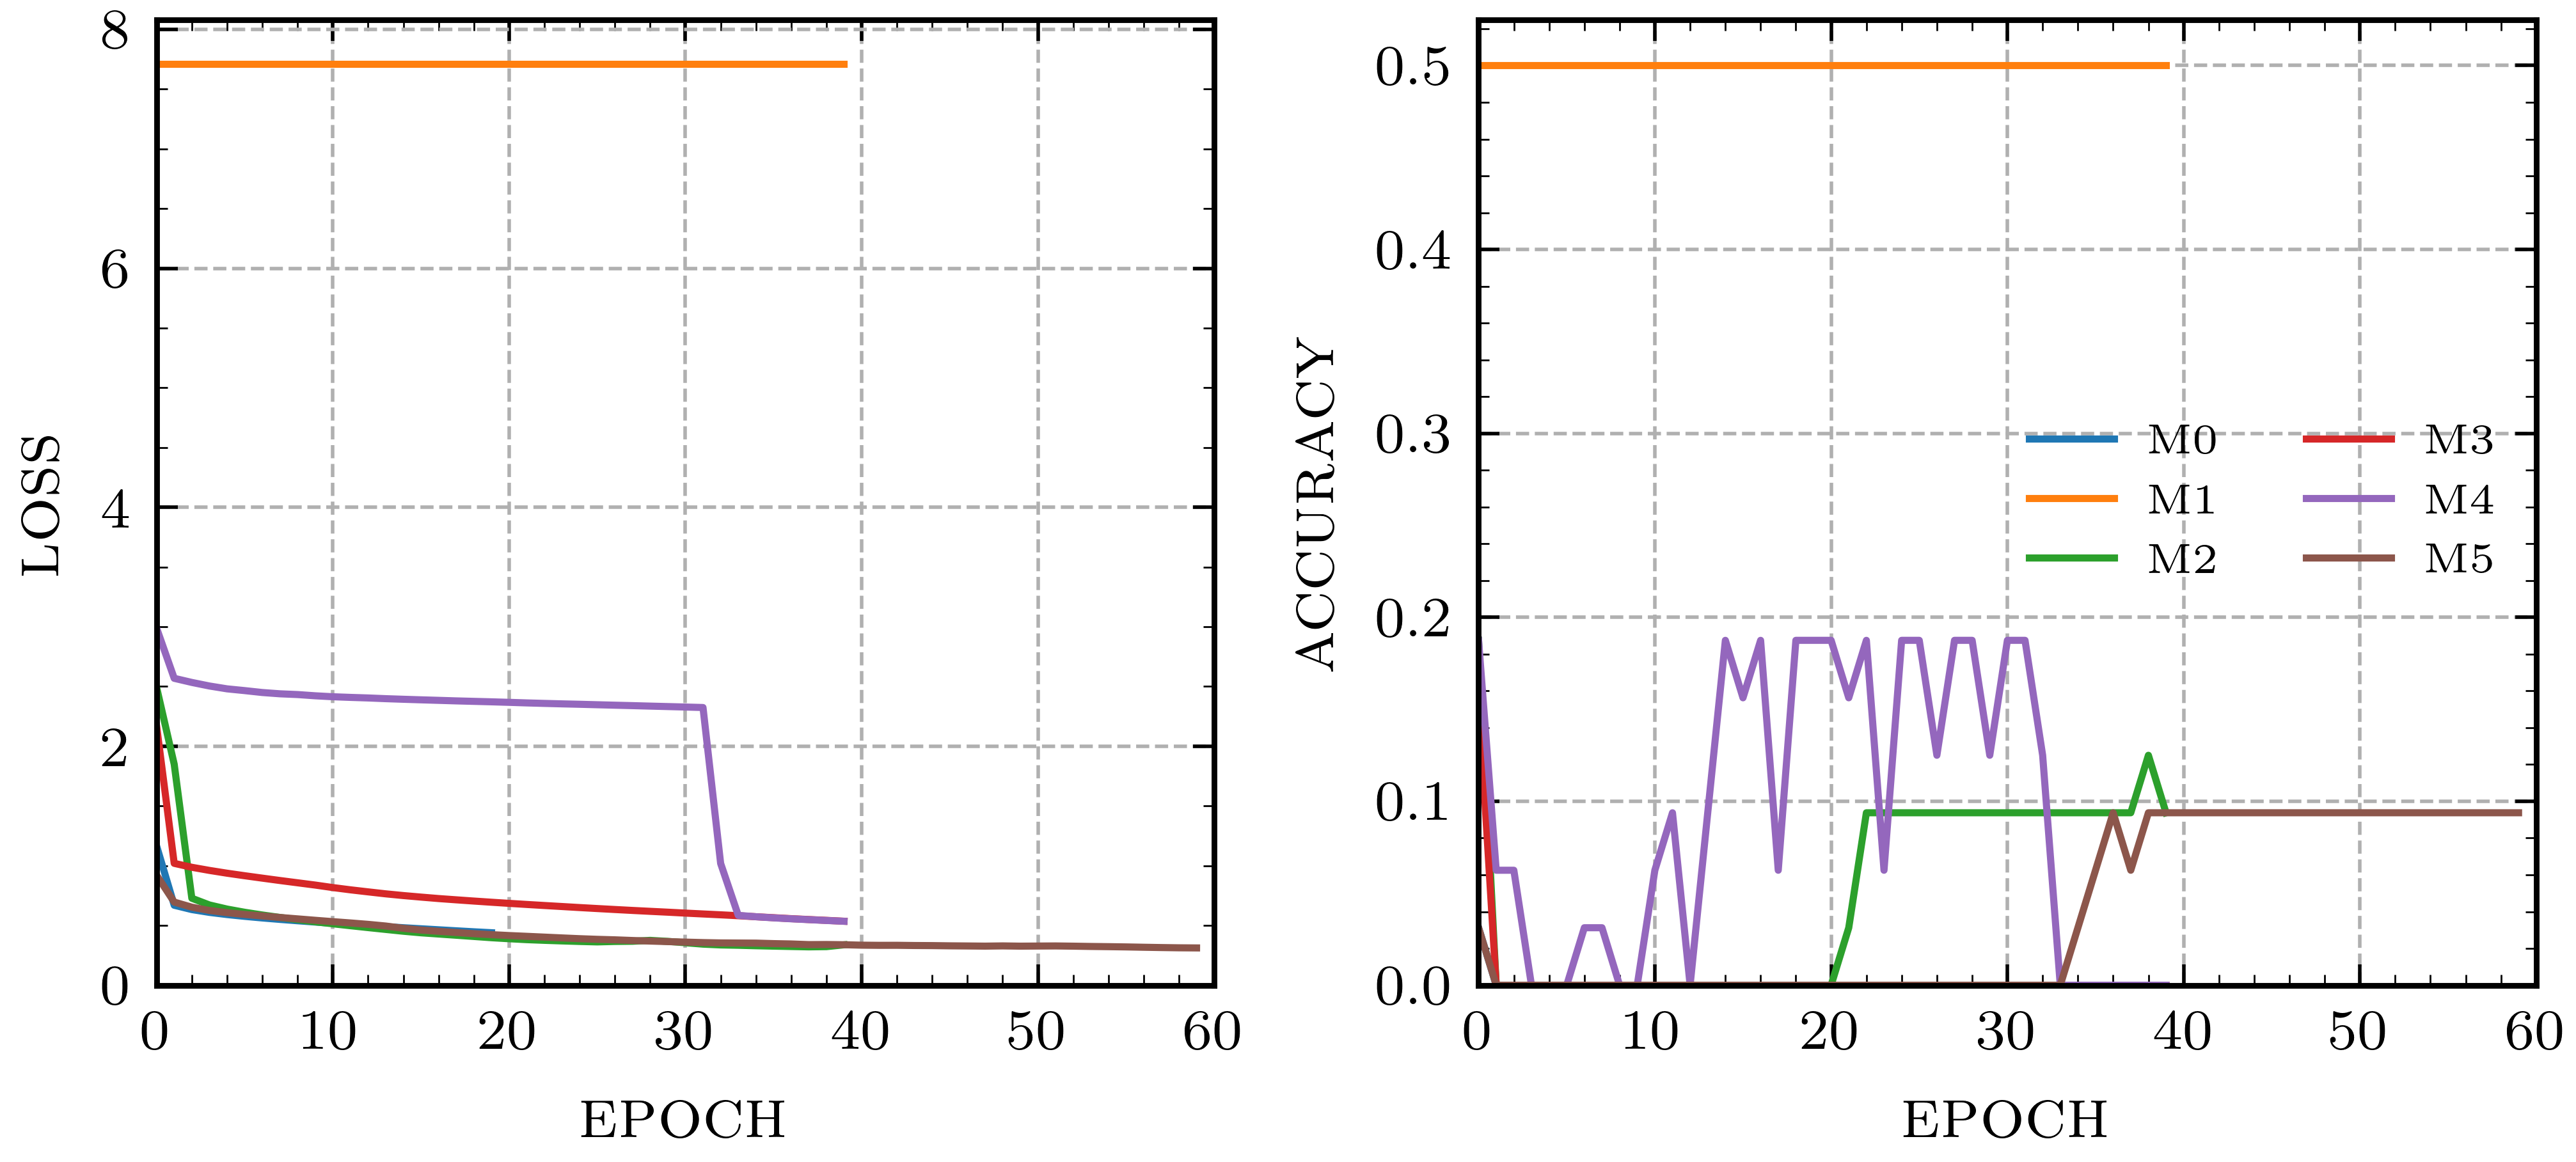

In [35]:
fig = plt.figure(figsize=(6, 2.5), facecolor='white')
gs = fig.add_gridspec(ncols=2, nrows=1, hspace=0, wspace=.25)
axs = gs.subplots(sharex=True, sharey=False)

for ax in axs:
    ax.tick_params(which='both', direction="in")
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', lw=.5)
    ax.minorticks_on()
    ax.set_xlabel(r'\textsc{epoch}')
    ax.set_xlim(0, xmax)

# Loss
axs[0].set_ylabel(r'\textsc{loss}')
for i in range(len(models_params.keys())):
    axs[0].plot(histories[i].history['loss'],
                color=models_params[f'm{i}']['COLOR'],
                ls='-', lw=1, label=f'M{i}')
    # axs[0].plot(histories[i].history['val_loss'],
    #             color=models_params[f'm{i}']['COLOR'],
    #             ls='--',  lw=1, label=f'M{i}_ValLoss')

# Accuracy
axs[1].set_ylabel(r'\textsc{accuracy}')
for i in range(len(models_params.keys())):
    axs[1].plot(histories[i].history['accuracy'],
                color=models_params[f'm{i}']['COLOR'],
                ls='-', lw=1, label=f'M{i}')
    # axs[1].plot(histories[i].history['val_accuracy'],
    #             color=models_params[f'm{i}']['COLOR'],
    #             ls='-', lw=1, label=f'M{i}_ValAccuracy')
axs[1].legend(framealpha=0, ncol=2)

for ax in axs:
    ax.set_ylim(0, ax.get_ylim()[1])

fig.savefig('../images/tp1_fig2.pdf')
plt.show()

## Clasificación y validación

In [23]:
y_preds = []
for i in range(len(models_params.keys())):
    y_preds.append(models[i].predict(feats_test))

1/1 [==============================] - 0s 63ms/step


In [24]:
# Assign all values greater than 1 to 1
y_preds = np.array(y_preds)
y_preds[y_preds > 1] = 1.0

In [25]:
cms = []
for i in range(len(models_params.keys())):
    cms.append(confusion_matrix(np.round(y_preds[i]),
                                target_test,
                                labels=[0., 1.]))

In [26]:
# Confusion matrix structure
# TN | FP
# FN | TP

# Print confusion matrices
for i in range(len(models_params.keys())):
    print(f'Model M{i}:')
    for row in cms[i]:
        print('\t\t\t' + ' '.join(map(str, row)))

Model M0:
			4 2
			0 5
Model M1:
			4 7
			0 0
Model M2:
			4 4
			0 3
Model M3:
			4 2
			0 5
Model M4:
			3 1
			1 6
Model M5:
			4 2
			0 5


In [27]:
# print(np.diag(cm).sum() / cm.sum())
for i in range(len(models_params.keys())):
    print(f'Model M{i}:\t', end='')
    print(accuracy_score(target_test, np.round(y_preds[i])))

Model M0:	0.8181818181818182
Model M1:	0.36363636363636365
Model M2:	0.6363636363636364
Model M3:	0.8181818181818182
Model M4:	0.8181818181818182
Model M5:	0.8181818181818182
